<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl_2/blob/main/Gillespie_redes_markoviano.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algoritmo Gillespie en redes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time

#Cadenas de Markov

## Ley de Acción de Masas.

Cuando consideramos que cada particula/individuo tiene un posible contacto con cualquier otra del sistema, el número de interacciones Susceptible-Infeccioso corresponde a $S(t)\cdot I(t)$. Éste supuesto es equivalente a que la epidemia se considere en una gráfica completa.\\ \\
Si $\beta$ es la tasa de infección, para cada individuo susceptible en $S(t)$, por ser gráfica completa, sabemos que tiene contacto con exactamente $I(t)$ individuos infecciosos, por lo que el número de contactos Susceptible-Infeccioso es $S(t)\cdot I(t)$ y por lo tanto consideramos 2 procesos de Poisson independientes de tasas $\beta\cdot S(t)I(t)$, $\gamma\cdot I(t)$, para infección y recuperación, respectivamente. \\

In [3]:
def Gillespie_Markov_Chain_MA(N,S_0,I_0,R_0,beta,gamma,T=np.inf):
  X_S,X_I,X_R=S_0,I_0,R_0
  t=0
  H=[[0,X_S,X_I]]
  while(X_I>0 and t<T):
    lammbda_inf=(beta/N)*X_S*X_I
    lammbda_rec=gamma*X_I
    lammmbda_tol=lammbda_inf+lammbda_rec
    t+=np.random.exponential(scale=1/(lammmbda_tol))
    u_2=np.random.uniform(0,1)
    if(u_2<lammbda_inf/lammmbda_tol):#Infeccion
        X_I+=1
        X_S-=1
    else:#Recuperación
        X_I-=1
        X_R+=1
    H.append([t,X_S,X_I])
  return pd.DataFrame(H,columns=['time','S(t)','I(t)'])

0.42132139205932617 s.  en 3 simulaciones para N=10e4
1.2421085834503174 s.  en 3 simulaciones para N=10e5
15.11622929573059 s.  en 3 simulaciones para N=10e6


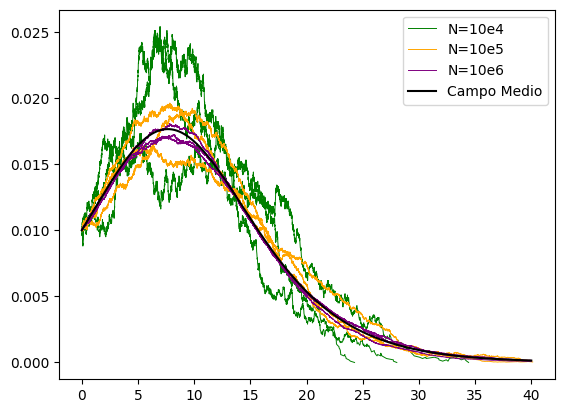

20.2408127784729 s. en total


In [8]:
## Ejemplo
start_0=time.time()
np.random.seed(0)
for power in [4,5,6]:
  start_1=time.time()
  beta=1.15
  gamma=1
  N=10**power
  p_i_0=0.01
  I_0=int(p_i_0*N)
  S_0=N-I_0
  R_0=0
  colores=['green','orange','purple']
  for iter in range(3):
    if(iter==0):
      H=Gillespie_Markov_Chain_MA(N,S_0,I_0,R_0,beta,gamma,T=40)
      plt.plot(H['time'],H['I(t)']/N,colores[int(power-4)],linewidth=0.7,label='N=10e'+str(power))
    else:
      H=Gillespie_Markov_Chain_MA(N,S_0,I_0,R_0,beta,gamma,T=40)
      plt.plot(H['time'],H['I(t)']/N,colores[int(power-4)],linewidth=0.7)
  print(time.time()-start_1, "s.  en 3 simulaciones para N=10e"+str(power))
#----------------------------------Campo Medio
from scipy.integrate import odeint
import scipy.integrate as spi
def ode_SIR(INP,t,ps): #Codigo hurtado del dropbox.
    try:
        beta = ps['beta'].value
        gamma = ps['gamma'].value
        N = ps['N'].value
    except:
        beta,gamma,N = ps
    Y = np.zeros((3))
    V = INP
    Y[0] = - beta * V[0] * V[1] /N
    Y[1] = beta * V[0] * V[1]/N - gamma * V[1]
    Y[2] = gamma * V[1]
    return Y
def g(t,INP,ps):
    SOL = spi.odeint(ode_SIR,INPUT,t_range,args=(ps,))
    return SOL[:,1]

INPUT = (S_0, I_0, 0.0)
t_start = 0.0; t_end = 40; t_inc = .01
t_range = np.arange(t_start, t_end+t_inc, t_inc)
plt.plot(t_range,g(t_range,INPUT,[beta,gamma,N])/N, 'k',label='Campo Medio')
#----------------------------------
plt.legend()
plt.savefig('markoviano_convergencia.png',dpi=300)
plt.show()
print(time.time()-start_0, 's. en total')

## Aproximación a redes Erdos-Renyi G(n,p)

Cuando el grado promedio de un vértice arbitrario no es $n-1$, es decir, la gráfica no es completa, se elimina el supuesto de Ley de Acción de Masas y consideramos la función $N_{SI}(k)$ que cuenta el número de aristas Susceptibles-Infeccioso dependiendo del número de individuos infecciosos en la gráfica, k.

Consideramos la aproximación dada de suponer que dados $k_s$ individuos susceptibles y $k_i$ infecciosos, éstos se distribuyen uniformemente sobre la gráfica, obteniendo
$$\hat{N}_{SI}(k_s,k_i)=k_sk_ip,$$
donde $p$ es la probabilidad de que una arista se crea en el modelo de Erdos-Renyi $G(n,p)$.

# Redes

In [14]:
def Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes):
    Lambda=np.sum(Lambdas)
    tau=np.random.exponential(scale=1/Lambda)
    u_2=np.random.uniform(0,1)
    if(u_2<(Lambda-Lambdas[-1])/Lambda):#Infeccion
        u_3=np.random.uniform(0,1)
        D=0
        k=0
        while(u_3>D):
            D+=Lambdas[k]/(Lambda-Lambdas[-1])
            k+=1
        new_reaction_index=np.random.choice(range(len(dict_num_contacts[str(k-1)])))
        new_reaction=dict_num_contacts[str(k-1)][new_reaction_index]
    else:#Recuperación
        k=0
        new_reaction_index=np.random.choice(range(len(X_I_indexes)))
        new_reaction=X_I_indexes[new_reaction_index]
    return tau,new_reaction,k-1,new_reaction_index
def Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes,G_network_initial=nx.Graph(),T=np.inf):
    flag=True
    #Paso 1.
    t=0 #Inicializar $t=0$.
    #Calcular $k_i$ el número de contactos infecciosos del individuo $i$.--------------------
    X_I=len(X_I_indexes)
    X_S=N-X_I
    Historia=[[0,X_S,X_I]]
    dict_num_contacts = {}
    for n in range(X_I+1):
        dict_num_contacts[str(n)]=[]
    num_cont_inf_por_indice=np.zeros(N)
    for i in range(N):
        if(i not in X_I_indexes): #No es infeccioso.
            count_for_i=0
            for j in X_I_indexes:
                if (G_network_initial.has_edge(i,j)):#Es un contacto Susceptible-infeccioso.
                    num_cont_inf_por_indice[i]+=1#Ya que voy a hacer los ciclos, mejor la guardo igual.
                    count_for_i+=1
            dict_num_contacts[str(count_for_i)].append(i)
    #-------------------------------------------
    while(flag):
        #Generar las Lambdas------------------
        Lambda=0
        Lambdas=[]
        for k in range(len(list(dict_num_contacts.keys()))):
            Lambdas.append((beta/N)*len(dict_num_contacts[str(k)])*k)#
            Lambda+=Lambdas[-1]
        Lambdas.append(gamma*X_I)
        Lambda+=Lambdas[-1]
        #-------------------------------------------
        #Paso Monte-Carlo---------------------------
        tau,new_reaction,k_choice,new_reaction_index=Monte_Carlo_Step_exp(Lambdas,dict_num_contacts,X_I_indexes)
        #-------------------------------------------
        #Actualización del sistema.
        if(G_network_initial.nodes[new_reaction]['Estado:']=='Susceptible'):#Se trata de una infección
            num_cont_inf_por_indice[new_reaction]=0
            G_network_initial.nodes[new_reaction]['Estado:']='Infeccioso'#Actualizar su estado
            X_I_indexes.append(new_reaction)
            i=new_reaction
            dict_num_contacts[str(k_choice)].pop(new_reaction_index)#Saca al nuevo infeccioso del conjunto con exactamente k_choice contactos infecciosos.
            #Para cada nodo $j$ conectado a $i$, actualizamos su número de contactos infecciosos como $k_j=k_j+1.$--------------------
            num_max_cont=int(list(dict_num_contacts.keys())[-1])
            for vecino in G_network_initial.neighbors(i):#Para cada vecino del nuevo infectado, le aumentamos el numero de contactos en 1. (lo agregamos a la siguiente categoria y lo sacamos de la anterior)
                if (G_network_initial.nodes[vecino]['Estado:']=='Susceptible'):

                    num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                    if(num_cont_del_vecino+1>num_max_cont):#Si mas de uno crea una categoria, hay error.
                        num_max_cont+=1
                        dict_num_contacts[str(int(num_cont_del_vecino+1))]=[vecino]
                    else:
                        dict_num_contacts[str(int(num_cont_del_vecino+1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]+=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        else:
            G_network_initial.nodes[new_reaction]['Estado:']='Recuperado'
            num_cont_inf_por_indice[new_reaction]=0#Ya no es relevante
            X_I_indexes.pop(new_reaction_index)
            i=new_reaction
            #Para cada nodo $j$ conectado a $i^* $, actualizamos su número de contactos infecciosos como $k_j=k_j-1.$
            for vecino in G_network_initial.neighbors(i):#Podria ser que ya no tuviera ningun contacto
                num_cont_del_vecino=num_cont_inf_por_indice[vecino]
                if(num_cont_del_vecino!=0):# Es recuperado.
                    dict_num_contacts[str(int(num_cont_del_vecino-1))].append(vecino)
                    dict_num_contacts[str(int(num_cont_del_vecino))].remove(vecino)
                    num_cont_inf_por_indice[vecino]-=1#Actualizamos ambas fuentes de informacion
            #-------------------------------------------
        t+=tau #Actualiza el tiempo $t=t+\tau$.
        X_I=len(X_I_indexes)
        X_S=N-X_I
        Historia.append([t,X_S,X_I])#Focus
        if(X_I==0 or t>T):
            flag=False
    return pd.DataFrame(Historia,columns=['time','S(t)','I(t)'])

Empieza
Tomó 0.7611799240112305s. para 5 iteraciones con N=10e2
Empieza
Tomó 6.991824626922607s. para 5 iteraciones con N=10e3
Empieza
Tomó 582.0325264930725s. para 5 iteraciones con N=10e4


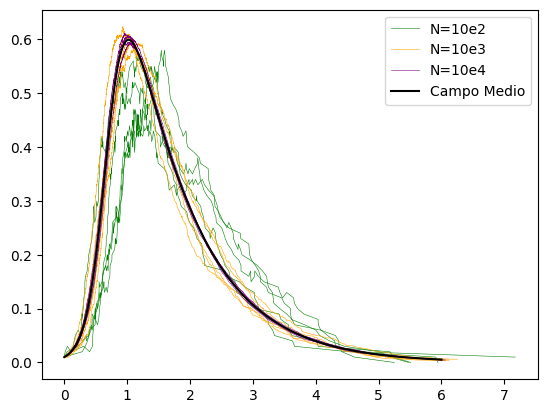

In [17]:
#Ejemplo
import time
colores=['green','orange','purple']
np.random.seed(0)
for pot in [2,3,4]:
    iter_time = time.time()
    beta=75
    gamma=1
    N=10**pot
    ksum=1
    G=nx.fast_gnp_random_graph(n=N, p=0.1, seed=None, directed=False)
    X_I_indexes=np.random.choice(N,size=int(N*0.01),replace=False).tolist()
    for k in range(N):
        if k in X_I_indexes:
            G.nodes[k]['Estado:']='Infeccioso'
        else:
            G.nodes[k]['Estado:']='Susceptible'
    print("Empieza")
    #------------------------------------ Markoviano
    for iter in range(5):
        H=[]
        while(len(H)<10):
          G_copy=G.copy()
          X_I_indexes_copy=X_I_indexes.copy()
          H=Gillespie_Direct_Method_Network(beta,gamma,N,X_I_indexes=X_I_indexes_copy,G_network_initial=G_copy,T=6)
        if(iter==0):
            plt.plot(H['time'],H['I(t)']/N, colores[pot-2],linewidth=0.4,label='N=10e'+str(pot))
        else:
            plt.plot(H['time'],H['I(t)']/N, colores[pot-2],linewidth=0.4)
        #------------------------------------
    print("Tomó "+str(time.time()-iter_time)+'s. para 5 iteraciones con N=10e'+str(pot))
INPUT = (0.99*N, 0.01*N, 0.0)
t_start = 0.0; t_end = 6; t_inc = .01
t_range = np.arange(t_start, t_end+t_inc, t_inc)
plt.plot(t_range,g(t_range,INPUT,[beta*0.1,gamma,N])/N, 'k',label='Campo Medio')
plt.legend()
plt.savefig('markoviano_convergencia_gnp.png',dpi=300)
plt.show()